# Multi-Nomial Classification Model

This notebook is to create the prediction model for user input on the application. Since the data has already been clustered, a classification model will be trained to pick up the values in the clusters based on the observation's vectorized text information.

In [1]:
# pip install imblearn

In [2]:
# Imports
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingRegressor

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
import numpy as np

In [3]:
#Read in the cluster data from the previous notebook model
geoconfirmed_clusters = pd.read_csv('../data/get_geoconfirmed_data_clusters.csv')

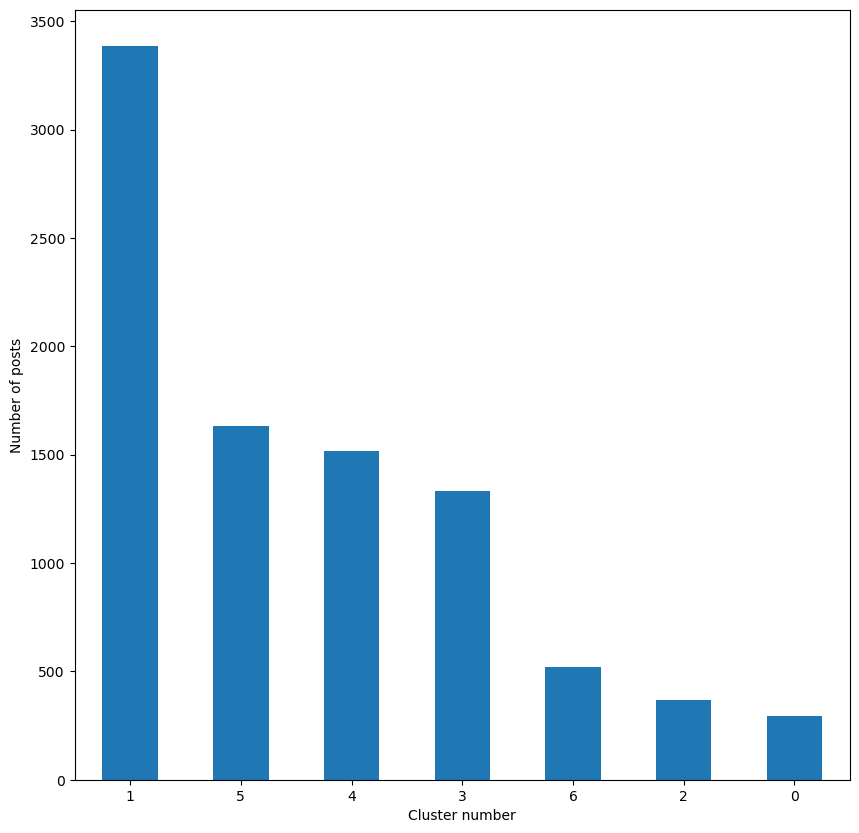

In [4]:
#Plot number of posts by cluster

plt.figure(figsize=(10,10))
geoconfirmed_clusters.groupby('clusters').size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=0)
plt.xlabel("Cluster number")
plt.ylabel("Number of posts")
plt.show()

In [5]:
stpwrd = stopwords.words('english')
new_stopwords = ["twitter", 'geoconfirmed', 'com', 'br', 'https', 'geo', 'png',
                 'status', 'vid', 'f', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 
                'sep', 'oct', 'nov', 'dec', 'Æ', 'ô', 'ö', 'ò', 'û', 'ù', 'ÿ', 'á', 'í', 'ó', 'ú', 'ñ', 'Ñ', 'Š', 'š', 'ý', 'ü',
                'õ', 'ð', 'ã', 'Ý', 'Ü', 'Û', 'Ú', 'Ù', 'Ï', 'Î', 'Í', 'Ì', 'Ë', 'Ê', 'É', 'È', 'Å', 'Ä', 'Ã', 'Â', 'Á', 'À', 'Ö', 'Õ', 'Ô','Ó', 'Ò',
                'ÂƒÆ', 'â', 'Âƒâ', 'šâ', 'šÂ', 'Ž', 'žÂ', 'ÃƒÆ', 'Ãƒâ', 'ƒ', 'šÃ'  ] #add update to this
stpwrd.extend(new_stopwords)

In [6]:
def review_to_wordlist(review, remove_stopwords=True):
    # Clean the text, with the option to remove stopwords.
    
    # Convert words to lower case and split them
    words = review.lower().split()

    # Optionally remove stop words (true by default)
    if remove_stopwords:
        words = [w for w in words if not w in stpwrd]
    
    review_text = " ".join(words)

    # Clean the text
    review_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", review_text)
    review_text = re.sub(r"\'s", " 's ", review_text)
    review_text = re.sub(r"\'ve", " 've ", review_text)
    review_text = re.sub(r"n\'t", " 't ", review_text)
    review_text = re.sub(r"\'re", " 're ", review_text)
    review_text = re.sub(r"\'d", " 'd ", review_text)
    review_text = re.sub(r"\'ll", " 'll ", review_text)
    review_text = re.sub(r",", " ", review_text)
    review_text = re.sub(r"\.", " ", review_text)
    review_text = re.sub(r"!", " ", review_text)
    review_text = re.sub(r"\(", " ( ", review_text)
    review_text = re.sub(r"\)", " ) ", review_text)
    review_text = re.sub(r"\?", " ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    for i in new_stopwords:
        review_text = re.sub(i, " ", review_text)
    words = review_text.split()
    
    # Shorten words to their stems
    stemmer = SnowballStemmer('english', ignore_stopwords = True)
    stemmed_words = [stemmer.stem(word) for word in words]
    
    review_text = " ".join(stemmed_words)
    
    # Return a list of words
    return(review_text)

In [36]:
#review text and create a dataframe of post features, just doing it for geoconfirmed right now
postfeatures = []

for i in geoconfirmed_clusters['list_text']:
    postfeatures.append(review_to_wordlist(i, remove_stopwords=True))

In [8]:
#Vectorize them
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(postfeatures)

In [9]:
# Start to build the model. I am using this guide for assistance
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
y = geoconfirmed_clusters['clusters']

In [10]:
# Get baseline accuracy reading
y.value_counts(normalize = True) #have to beat 37 percent

1    0.374047
5    0.180502
4    0.167680
3    0.147452
6    0.057257
2    0.040787
0    0.032276
Name: clusters, dtype: float64

In [11]:
#Train-test-split the X, y to help evaluate performance
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [12]:
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.960 (0.007)


In [13]:
model.fit(X_train, y_train)
print(f'Logistic Regression Accuracy: {model.score(X_train, y_train)}')
print(f'Logistic Regression Accuracy: {model.score(X_test, y_test)}')

Logistic Regression Accuracy: 0.9948415622697127
Logistic Regression Accuracy: 0.9633068081343943


In [14]:
# With these accuracy scores, I am fine with how the model turns out.
# Pickle this
with open("../data/class_model.pkl", 'wb') as picklefile:
    pickle.dump(model, picklefile)